In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.7 MB/s eta 0:00:00


In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

sampling_rate = 256

# frequency bands
alpha_band = (8, 13)
theta_band = (4, 8)
beta_band = (13, 20)
delta_band = (0.5, 4)

# Selected channels (convert to 0-indexed)
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]

# Power function using CWT
def compute_power_cwt(signal, scales, wavelet):
    coeffs, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coeffs) ** 2  # Power

# Initialize list for relative power features
all_relative_features = []

# Replace this with your actual participant list
train_participants = [1, 2, 3]  # Example participant IDs

for participant in train_participants:
    file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(file_path)
    participant_data = data['train_data']

    trial_duration = 1.5
    segment_duration = 20
    trials_per_segment = int(segment_duration / trial_duration)
    window_duration = 5
    window_length = window_duration * sampling_rate
    overlap = 0.5
    step_size = int(window_length * (1 - overlap))

    for start in range(0, participant_data.shape[2] - trials_per_segment + 1, trials_per_segment):
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])
        segment_signal = segment_signal[:20 * sampling_rate, :]

        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]

            wavelet = 'cmor1.0-0.5'
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)
            scales_beta = pywt.frequency2scale(wavelet, np.array(beta_band) / sampling_rate)
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_delta = pywt.frequency2scale(wavelet, np.array(delta_band) / sampling_rate)

            window_features = []

            for channel in range(len(selected_channels)):
                alpha = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).sum()
                beta = compute_power_cwt(window_signal[:, channel], scales_beta, wavelet).sum()
                theta = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).sum()
                delta = compute_power_cwt(window_signal[:, channel], scales_delta, wavelet).sum()

                total_power = alpha + beta + theta + delta + 1e-10  # Avoid divide-by-zero
                relative_alpha = alpha / total_power
                relative_beta = beta / total_power
                relative_theta = theta / total_power
                relative_delta = delta / total_power

                window_features.append([relative_beta, relative_alpha, relative_delta, relative_theta])

            # Average across channels
            window_features = np.mean(window_features, axis=0)
            all_relative_features.append(window_features)

# Convert to numpy array
features = np.array(all_relative_features)

In [5]:
# Normalize
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Save scaler
joblib.dump(scaler, "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_Combined_Relative_Power_Scaler.pkl")



['/content/drive/MyDrive/Dataset/clustering_models/Kmeans_Combined_Relative_Power_Scaler.pkl']

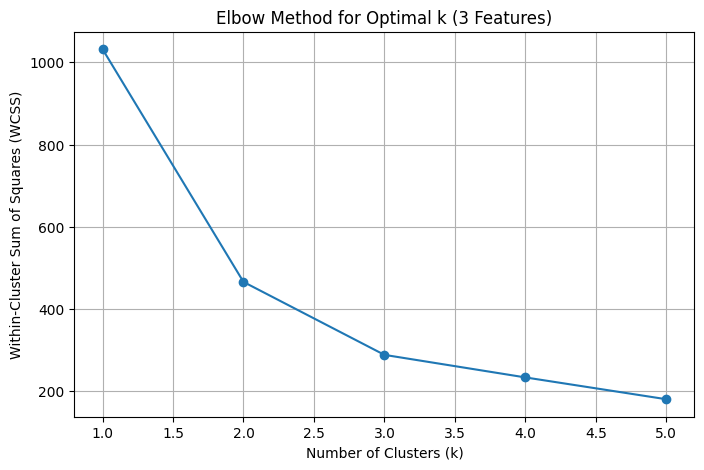

In [6]:
# Determine the optimal number of clusters using the elbow method
wcss = []
K_range = range(1, 6)  # Test 1 to 5 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(normalized_features)
    wcss.append(kmeans.inertia_)  # Inertia (within-cluster sum of squares)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (3 Features)')
plt.grid()
plt.show()

For n_clusters = 2, the average silhouette score is 0.456
For n_clusters = 3, the average silhouette score is 0.409
For n_clusters = 4, the average silhouette score is 0.355
For n_clusters = 5, the average silhouette score is 0.349
For n_clusters = 6, the average silhouette score is 0.371


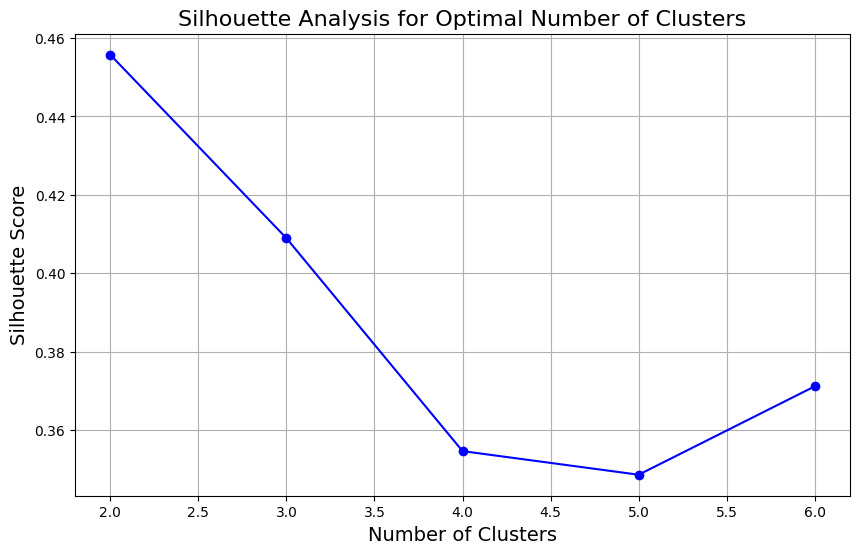

In [7]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

# Apply the silhouette method
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(normalized_features)
    silhouette_avg = silhouette_score(normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o', linestyle='-', color='blue')
plt.title("Silhouette Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid()
plt.show()

For n_clusters = 2, the Davies-Bouldin Index is 0.780
For n_clusters = 3, the Davies-Bouldin Index is 0.803
For n_clusters = 4, the Davies-Bouldin Index is 0.889
For n_clusters = 5, the Davies-Bouldin Index is 0.908
For n_clusters = 6, the Davies-Bouldin Index is 0.811


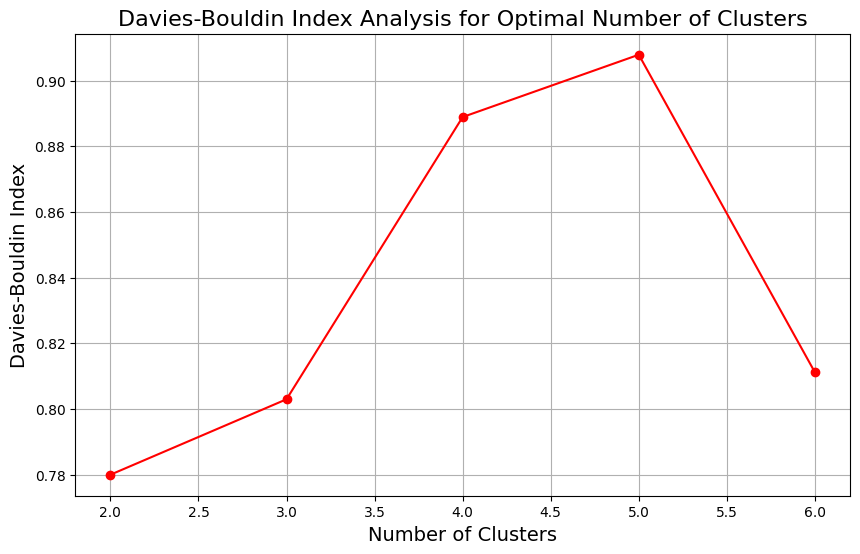

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

range_n_clusters = [2, 3, 4, 5, 6]
dbi_scores = []

# Loop through different numbers of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(normalized_features)
    dbi_score = davies_bouldin_score(normalized_features, cluster_labels)
    dbi_scores.append(dbi_score)
    print(f"For n_clusters = {n_clusters}, the Davies-Bouldin Index is {dbi_score:.3f}")

# Plot DBI scores for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, dbi_scores, marker='o', linestyle='-', color='red')
plt.title("Davies-Bouldin Index Analysis for Optimal Number of Clusters", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("Davies-Bouldin Index", fontsize=14)
plt.grid()
plt.show()



In [9]:
# Perform K-Means clustering on normalized features
optimal_k = 3  # Set based on the elbow method

kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
clusters = kmeans.fit_predict(normalized_features)

centroids = kmeans.cluster_centers_
print(f"centroids: {centroids}")

centroids: [[-0.04588444 -0.0199448   0.02367905  0.04428646]
 [ 1.23792     1.3421768  -1.3267853   1.0709403 ]
 [-1.0612004  -1.2062378   1.1850035  -1.0749061 ]]


Centroid 0: [ 1.41   1.34  -1.44   0.67 ]
Centroid 1: [-0.11  -0.04   0.06   0.12 ]
Centroid 2: [-1.02  -1.12   1.17  -0.87 ]
Features:     β     α      δ      θ


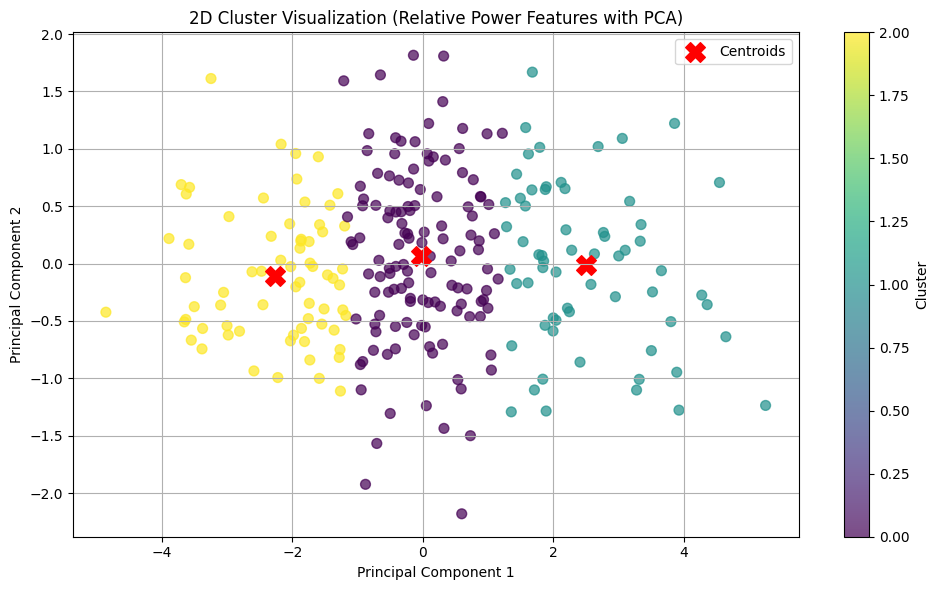

In [10]:

# Apply PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(normalized_features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(reduced_features)
joblib.dump(kmeans, "/content/drive/MyDrive/Dataset/clustering_models/Kmeans_combined_relative_power_Model.pkl")

# 📊 2D Visualization
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=clusters,
    cmap='viridis',
    s=50,
    alpha=0.7
)

# Plot centroids
centroids_2d = kmeans.cluster_centers_
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    color='red',
    marker='X',
    s=200,
    label='Centroids'
)

plt.title('2D Cluster Visualization (Relative Power Features with PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()